In [1]:
import math
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
N = 5000 # individual miners
M = 2 # mining pools
MAX_COUNT = 1000 #max time counter

In [3]:
# propability for pool i to mine a block
def P_mine(x, w, i):
    _sum = 0
    for j in range(M):
        _sum += x[j]*w[j]
    return w[i]*x[i]/_sum

In [4]:
# propability of orphaning
def P_orphan(s, param=0.005, T=600):
    return 1 - math.exp(-1*param*s/T)

In [5]:
# propability for pool i to win a block
def P_win(x, w, s, i, param, T=600):
    return P_mine(x,w,i) * math.exp(-1*param*s[i]/T)

In [6]:
# a miner's expected payoff in pool i
def y(x, w, s, i, param, R=1000, ro=2, T=600, p=0.01):
    _sum = 0
    for j in range(M):
        _sum += x[j]*w[j]
    return  (R + ro*s[i]) / (N * x[i]) * P_win(x,w,s,i,param) - p*w[i]

# average payoff of the induvidual miner in N
def ave_y(x, w, s, param):
    _sum = 0
    for i in range(M):
        _sum += y(x,w,s,i, param) * x[i]
    return _sum

In [7]:
# growth rate of size of pool iwith respect time t
def calc_dx1(x, w, s, i):
    return x[i] * (y(x,w,s,i,0.005) - ave_y(x,w,s,0.005))

def calc_dx2(x, w, s, i, R=1000, ro=2, param=0.005, T=600, p=0.01):
    a = (R + ro*s[i])*w[i]*math.exp(-1*param*s[i]/T)
    b = (R + ro*s[1-i])*w[1-i]*math.exp(-1*param*s[1-i]/T)
    
    x = x[i] * (1 - x[i]) * ((a - b) / (N*(w[0]*x[0] + w[1]*x[1])) - p*(w[i]-w[1-i]))
    return x

In [8]:
# the Nash Equilibria of the evolution game
def calc_x_NE(w, s, param, i, R=1000, ro=2, T=600, p=0.01):
    a = (R + ro*s[i])*w[i]*math.exp(-1*param*s[i]/T)
    b = (R + ro*s[1-i])*w[1-i]*math.exp(-1*param*s[1-i]/T)
    
    x = (a - b) / N / p / (w[i] - w[1-i])**2 - w[1-i] / (w[i] - w[1-i])  
    return x

100%|██████████| 1000/1000 [01:12<00:00, 13.74it/s]


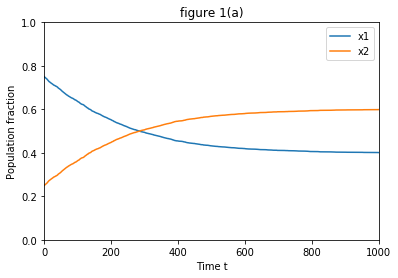

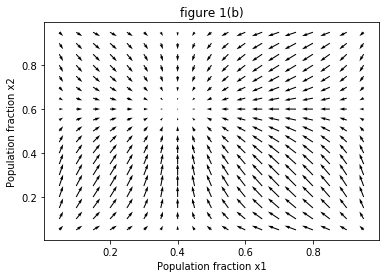

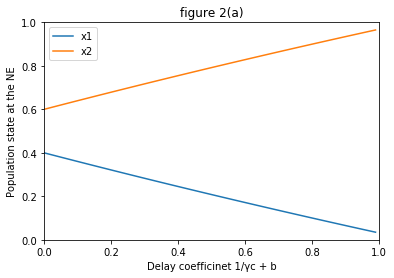

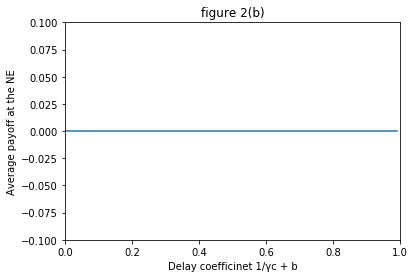

In [9]:
def two_mining_pool():
    # initialize parameter 
    x = [[0.75, 0.25]] # population states
    s = [100, 100] # block size
    w = [30, 20] # hash rate
    mi = [] # miner i's  mining pool selection
    
    # miner i randomly seslects a mining pool
    for i in range(N): 
        if i < int(N*x[0][0]):
            mi.append(0)
        else:
            mi.append(1)
    
    # calc the Nash Equilibria of the evolution game
#     X1_NE = calc_x_NE(w, s, 0.005, 0)
#     X2_NE = calc_x_NE(w, s, 0.005, 1)
#     print(X1_NE, X2_NE)
    
    for t in tqdm(range(MAX_COUNT)):
#         dx = []
#         for i in range(M):
#             dx.append(calc_dx2(x[t], w, s, i))
#         x.append([x[t][0] + dx[0], x[t][1] + dx[1]])
        
        for i in range(N):
            # random select mining pool
            j = random.randint(0, M-1)
            
            # probability of whether to switch from pool i to pool j
            p = x[t][j] * max(y(x[t],w,s,j, 0.005)-y(x[t],w,s,mi[i], 0.005), 0)
            
            if random.uniform(0,1)<=p:
                mi[i]=j
        x.append([np.sum(np.array(mi)==0)/N, np.sum(np.array(mi)==1)/N])
    
    # show figure 1(a)
    plt.title("figure 1(a)")
    plt.plot(range(MAX_COUNT), np.array(x)[0:MAX_COUNT,0:1], label='x1')
    plt.plot(range(MAX_COUNT), np.array(x)[0:MAX_COUNT,1:2], label='x2')
    plt.legend()
    plt.ylim(0,1)
    plt.xlim(0,MAX_COUNT)
    plt.xlabel("Time t")
    plt.ylabel("Population fraction")
    plt.show()
    
    # show figure1(b)
    dx1 = np.zeros((19,19))
    dx2 = np.zeros((19,19))
    x1 = np.arange(1, 20)/20
    x2 = np.arange(1, 20)/20
    for i1, x_1 in enumerate(x1):
        for i2, x_2 in enumerate(x2):
            dx1[i2,i1] = calc_dx2([x_1,1- x_1], w, s, 0)
            dx2[i2,i1] = calc_dx2([1-x_2, x_2], w, s, 1)
    
    plt.title("figure 1(b)")
    plt.quiver(x2, x1, dx1, dx2)
    plt.xlabel("Population fraction x1")
    plt.ylabel("Population fraction x2")
    plt.show()
    
    # show figure 2(a) (b)
    x1_NE = []
    x2_NE = []
    ave_NE = []
    params = np.arange(100)/100
    for param in params :
        NE1 = calc_x_NE(w, s, param, 0)
        NE2 = calc_x_NE(w, s, param, 1)
        x1_NE.append(NE1)
        x2_NE.append(NE2)
        ave_NE.append(ave_y([NE1, NE2], w, s, param))
    
    plt.title("figure 2(a)")
    plt.plot(params, x1_NE, label="x1")
    plt.plot(params, x2_NE, label="x2")
    plt.xlabel("Delay coefficinet 1/γc + b")
    plt.ylabel("Population state at the NE")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.show()
    
    # incorrect!!
    plt.title("figure 2(b)")
    plt.plot(params, ave_NE)
    plt.xlabel("Delay coefficinet 1/γc + b")
    plt.ylabel("Average payoff at the NE")
    plt.xlim(0, 1)
    plt.ylim(-0.1, 0.1)
    plt.show()
    
two_mining_pool()

In [10]:
N = 10000 # individual miners
M = 4 # mining pools
MAX_COUNT = 1000 #max time counter

In [11]:
# miner i randomly seslects a mining pool
def initial_select_pool(x):
    mi = []
    for i in range(M):
        for j in range(int(N*x[i])):
            mi.append(i)

    return mi

In [12]:
def calc_dx2(x, w, s, i, R=1000, ro=2, param=0.005, T=600, p=0.01):
    a = (R + ro*s[i])*w[i]*math.exp(-1*param*s[i]/T)
    b = (R + ro*s[1-i])*w[1-i]*math.exp(-1*param*s[1-i]/T)
    
    x = x[i] * (1 - x[i]) * ((a - b) / (N*(w[0]*x[0] + w[1]*x[1])) - p*(w[i]-w[1-i]))
    return x

100%|██████████| 1000/1000 [02:58<00:00,  6.04it/s]


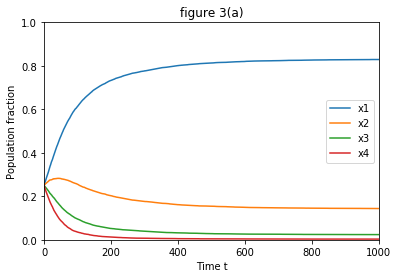

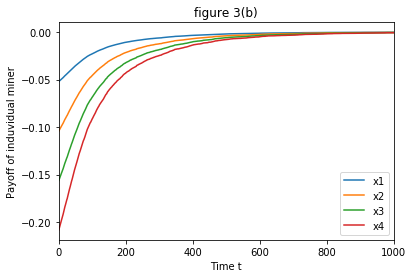

In [13]:
def four_mining_pool():
    # initialize parameters
    x = [[0.25, 0.25, 0.25, 0.25]]
    s = [100, 100, 100, 100]
    w = [10, 20, 30, 40]
    mi = initial_select_pool(x[0])
    y_t = []
    
    for t in tqdm(range(MAX_COUNT)):
        dx = []
        dy = []
        for i in range(M):
            #dx.append(x[t][i] + calc_dx2(x[t], w, s, i))
            dx.append(x[t][i] + calc_dx1(x[t], w, s, i))
            dy.append(y(x[t], w, s, i, 0.005))
        
        #x.append(dx)
        y_t.append(dy)
        
        for i in range(N):
            # random select mining pool
            j = random.randint(0, M-1)
            
            # probability of whether to switch from pool i to pool j
            p = x[t][j] * max(y(x[t],w,s,j,0.005)-y(x[t],w,s,mi[i],0.005), 0)
            
            if random.uniform(0,1) <= p:
                mi[i]=j
                
        dx = []
        for i in range(M):
            dx.append(np.sum(np.array(mi)==i)/N)
        x.append(dx)
        
    # show figure 3(a)
    plt.title("figure 3(a)")
    for i in range(M):
        plt.plot(range(MAX_COUNT), np.array(x)[0:MAX_COUNT,i:i+1], label='x'+str(i+1))
    plt.legend()
    plt.ylim(0,1)
    plt.xlim(0,MAX_COUNT)
    plt.xlabel("Time t")
    plt.ylabel("Population fraction")
    plt.show()
    
    # show figure 3(b)
    plt.title("figure 3(b)")
    for i in range(M):
        plt.plot(range(MAX_COUNT), np.array(y_t)[0:MAX_COUNT, i:i+1], label='x'+str(i+1))
    plt.xlim(0,MAX_COUNT)
    plt.xlabel("Time t")
    plt.ylabel("Payoff of induvidual miner")
    plt.legend()
    plt.show()
    
four_mining_pool()